# Science

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [24]:
# Reading the data from science revisions and science items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/science_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/science.csv')

In [25]:
print("Number of Revisions in Science Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Science Dataset")
print(items.shape)

Number of Revisions in Science Dataset
(44128, 12)
Number of Wikidata Items in Science Dataset
(14731, 3)


# Data Cleaning


In [26]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [27]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [28]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [29]:
rev.shape

(44128, 9)

In [30]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [31]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [32]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [33]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [34]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [35]:
editscount = rev['qid'].value_counts()

In [36]:
editscount.describe()

count    14672.000000
mean         2.988481
std          4.477704
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        131.000000
Name: qid, dtype: float64

In [37]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [38]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
7856
Items with No of Edits = 2
1871
Items with No of Edits = 3
1622
Items with No of Edits = 4
733
Items with No of Edits = 5
589
Items with No of Edits <= 5
12671


In [39]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [40]:
df_editscount.shape

(2001, 2)

In [41]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [42]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [43]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [45]:
print(df_editscount.head())# Checking for Wikipedia Q52 and Wikidata Q2013 items
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

         qid  editscount
0  Q25706608         131
1        Q52         126
2   Q1276073         105
3    Q207902         101
4     Q39286          76
   qid  editscount
1  Q52         126
Empty DataFrame
Columns: [qid, editscount]
Index: []


In [46]:
# Removing wikipedia item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q52'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q52'].index
rev = rev.drop(to_remove_from_rev)

In [47]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q52'])

         qid  editscount
0  Q25706608         131
2   Q1276073         105
3    Q207902         101
4     Q39286          76
5     Q14116          73
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


In [48]:
print("Number of Revisions in Science Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Science Dataset after Data Cleaning")
science_items = rev['qid'].value_counts()
print(science_items.shape)

Number of Revisions in Science Dataset after Data Cleaning
(21380, 10)
Number of Wikidata Items in Science Dataset after Data Cleaning
(2000,)


# Descriptive Statistics

In [49]:
print(science_items.describe().astype(int))

count    2000
mean       10
std         7
min         6
25%         7
50%         8
75%        11
max       131
Name: qid, dtype: int32


In [50]:
# converting a series to a dataframe
s_items = pd.DataFrame({'type':science_items.index, 'count':science_items.values})

In [51]:
# Items between the median and 75th percentile
print(s_items[(s_items['count'] >= 8) & (s_items['count'] < 11)])
# Items in the top 25% of the dataset
print(s_items[s_items['count'] >= 11])
# Items below median that is items that fall in the fist 50%
print(s_items[s_items['count'] < 8])
# Items that form the low 25% of the dataset
print(s_items[s_items['count'] < 7])
# Items that are part of 75% of the dataset
print(s_items[s_items['count'] < 11])

           type  count
576   Q27479815     10
577   Q19969536     10
578   Q27901850     10
579   Q24655086     10
580   Q27596184     10
...         ...    ...
1221    Q427415      8
1222  Q27861486      8
1223    Q968905      8
1224  Q19605500      8
1225  Q28049414      8

[650 rows x 2 columns]
          type  count
0    Q25706608    131
1     Q1276073    105
2      Q207902    101
3       Q39286     76
4       Q14116     73
..         ...    ...
571  Q27231654     11
572  Q28055391     11
573  Q27464669     11
574  Q28025206     11
575   Q6457027     11

[576 rows x 2 columns]
           type  count
1226  Q27967190      7
1227  Q20983436      7
1228    Q409184      7
1229   Q6203074      7
1230    Q952579      7
...         ...    ...
1995   Q1415581      6
1996   Q1026367      6
1997    Q415869      6
1998   Q7305434      6
1999  Q27940671      6

[774 rows x 2 columns]
           type  count
1581    Q757251      6
1582   Q1976068      6
1583   Q5659069      6
1584    Q215471     

# Statistics for Proxies

In [52]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [53]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

         count
type          
create   10026
add       6544
update    2588
set       1198
remove     822
revert      74
merge       55
undo        43
restore     29
protect      1


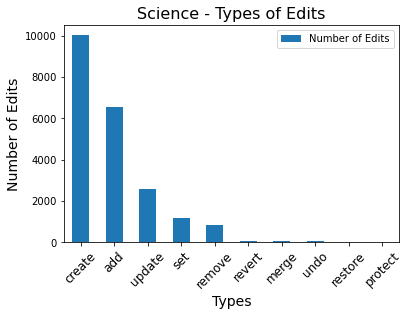

In [54]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Science - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [55]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[4, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

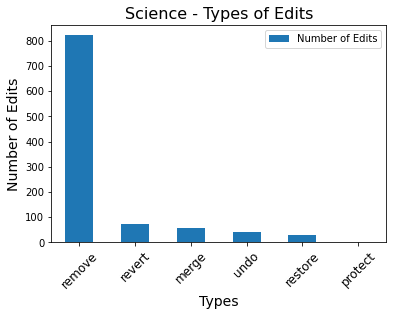

In [56]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Science - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [57]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
revert      74
merge       55
undo        43
restore     29
protect      1


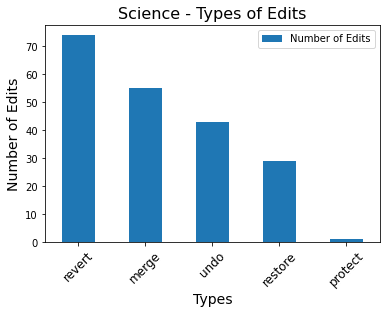

In [58]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Science - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [59]:
no_of_edits = science_items.to_numpy()

(array([774., 244., 221., 185., 211.,  48.,  38.,  14.,  49.,  22.,  15.,
         20.,  29.,  14.,  16.,   5.,  17.,  13.,   6.,   8.,  10.,   2.,
          8.,   0.,   7.,   1.,   0.,   3.,   2.,   3.,   2.,   1.,   2.,
          0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  6.  ,   7.25,   8.5 ,   9.75,  11.  ,  12.25,  13.5 ,  14.75,
         16.  ,  17.25,  18.5 ,  19.75,  21.  ,  22.25,  23.5 ,  24.75,
         26.  ,  27.25,  28.5 ,  29.75,  31.  ,  32.25,  33.5 ,  34.75,
         36.  ,  37.25,  38.5 ,  39.75,  41.  ,  42.25,  43.5 ,  44.75,
         46.  ,  47.25,  48.5 

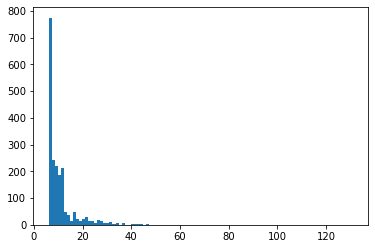

In [60]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

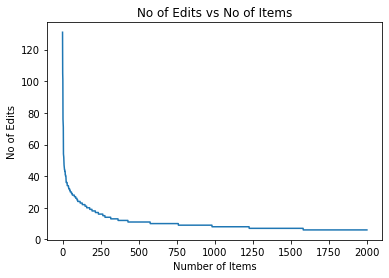

In [61]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [62]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [63]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [64]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [65]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [66]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [67]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [68]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [69]:
proxies = proxies.reset_index()

In [70]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [71]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [72]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [73]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [74]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [75]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.037000,0.027500,0.021500,0.014500,0.000500,0.411000,10.690000,2.666500
std,0.252315,0.169582,0.176219,0.127663,0.022361,1.878522,7.887649,2.485431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,4.000000
max,4.000000,2.000000,3.000000,2.000000,1.000000,58.000000,131.000000,33.000000


Text(0, 0.5, 'No of Edits')

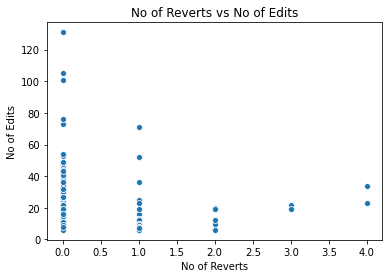

In [76]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

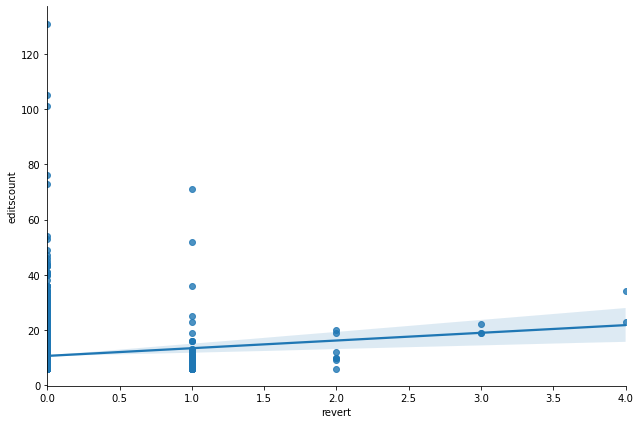

In [77]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [78]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.058047,0.218370,0.262881,0.262719,0.148378,0.089218,0.265380
merge,0.058047,1.000000,0.013685,-0.018428,-0.003628,0.033597,0.033678,0.102478
undo,0.218370,0.013685,1.000000,0.141791,0.124225,0.110811,0.101252,0.226539
restore,0.262881,-0.018428,0.141791,1.000000,0.347942,0.089865,0.064578,0.183944
protect,0.262719,-0.003628,0.124225,0.347942,1.000000,0.007015,0.023570,0.066010
remove,0.148378,0.033597,0.110811,0.089865,0.007015,1.000000,0.408442,0.200589
editscount,0.089218,0.033678,0.101252,0.064578,0.023570,0.408442,1.000000,0.151452
userscount,0.265380,0.102478,0.226539,0.183944,0.066010,0.200589,0.151452,1.000000


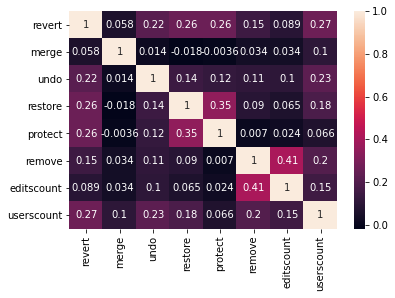

In [79]:
sns.heatmap(corr_matrix, annot=True)

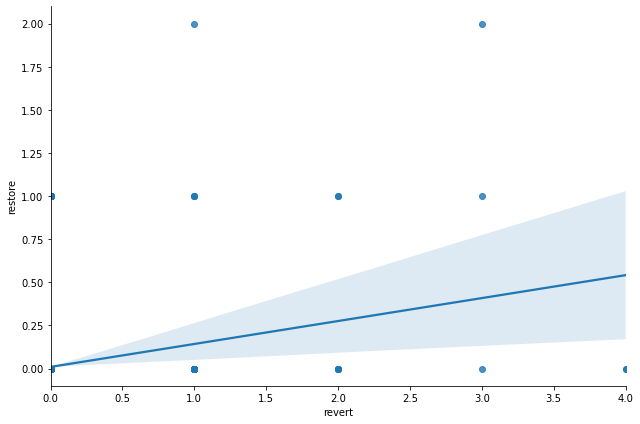

In [81]:
# restore and revert have positive correlation
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

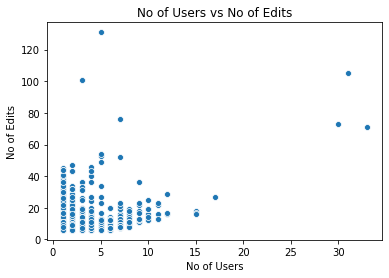

In [82]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

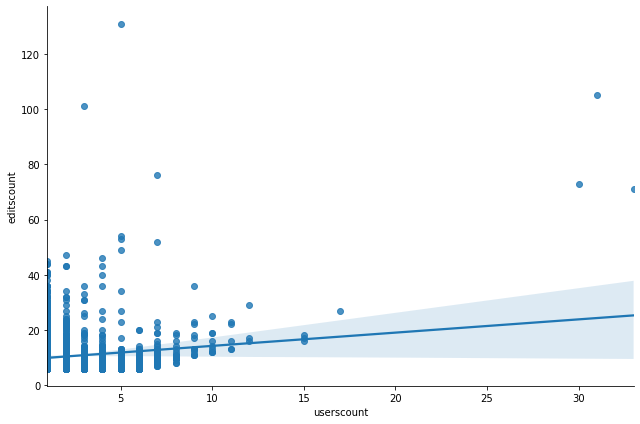

In [83]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [84]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [85]:
proxies.shape

(457, 9)

In [86]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
0,Q2152210,0,0,0,0,0,3,16,4
12,Q2307855,0,0,0,0,0,1,9,6
15,Q2328609,0,0,0,0,0,1,6,1
18,Q2363050,0,0,0,0,0,1,12,2
22,Q2377326,0,0,0,0,0,1,7,6
...,...,...,...,...,...,...,...,...,...
1914,Q28015896,0,0,0,0,0,1,7,2
1915,Q28018470,0,0,0,0,0,2,14,1
1917,Q28025076,0,0,0,0,0,1,17,1
1958,Q28035606,0,0,0,0,0,1,11,4


In [87]:
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [88]:
proxies_without_remove.shape

(149, 9)

In [89]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.338191,-0.005179,0.071225,0.260114,0.201082,0.084277,0.183245
merge,-0.338191,1.000000,-0.313527,-0.329008,-0.059538,-0.148344,-0.074520,-0.249039
undo,-0.005179,-0.313527,1.000000,-0.036803,0.100357,0.125148,0.131395,0.157142
restore,0.071225,-0.329008,-0.036803,1.000000,0.346341,0.080089,0.050270,0.085950
protect,0.260114,-0.059538,0.100357,0.346341,1.000000,-0.011121,0.032712,0.074677
remove,0.201082,-0.148344,0.125148,0.080089,-0.011121,1.000000,0.490858,0.284594
editscount,0.084277,-0.074520,0.131395,0.050270,0.032712,0.490858,1.000000,0.670171
userscount,0.183245,-0.249039,0.157142,0.085950,0.074677,0.284594,0.670171,1.000000


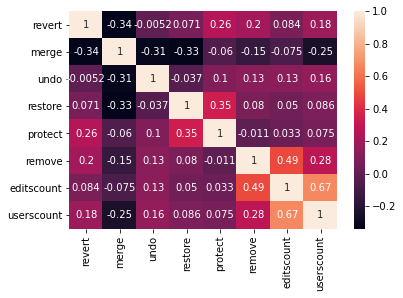

In [90]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Reverts

In [91]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [92]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
796,Q200180,4,0,0,0,0,18,34,5
802,Q206855,4,0,1,0,0,4,23,11
102,Q8449,3,0,3,1,0,1,19,8
103,Q8767,3,0,0,0,0,2,22,9
164,Q48183,3,0,1,2,1,1,19,10
33,Q2532873,2,0,0,1,0,1,9,5
64,Q373,2,0,0,0,0,0,10,7
109,Q10000,2,0,0,1,0,4,10,4
163,Q44996,2,0,0,0,0,2,20,6
169,Q54919,2,0,1,0,0,0,12,10


In [93]:
revert_item_labels = ['Vietnamese Wikipedia', 'Russian Wikipedia', 'Spanish Wikipedia', 'Domain Name System', 'German Wikipedia',
                     'NPAPI', 'Wikivoyage', 'Dutch Wikipedia', 'The Oxford English Dictionary', 'Virtual International Authority File', 
                     'Google Scholar', 'Meu Pé de Laranja Lima', 'People\'s Republic of China', 'gold', 'benzene', 
                     'biotechnology', 'ethology', 'Mount Kilimanjaro', 'pedagogy', 'trigonometry']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [94]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
796,Q200180,Vietnamese Wikipedia,4,0,0,0,0,18,34,5
802,Q206855,Russian Wikipedia,4,0,1,0,0,4,23,11
102,Q8449,Spanish Wikipedia,3,0,3,1,0,1,19,8
103,Q8767,Domain Name System,3,0,0,0,0,2,22,9
164,Q48183,German Wikipedia,3,0,1,2,1,1,19,10
33,Q2532873,NPAPI,2,0,0,1,0,1,9,5
64,Q373,Wikivoyage,2,0,0,0,0,0,10,7
109,Q10000,Dutch Wikipedia,2,0,0,1,0,4,10,4
163,Q44996,The Oxford English Dictionary,2,0,0,0,0,2,20,6
169,Q54919,Virtual International Authority File,2,0,1,0,0,0,12,10


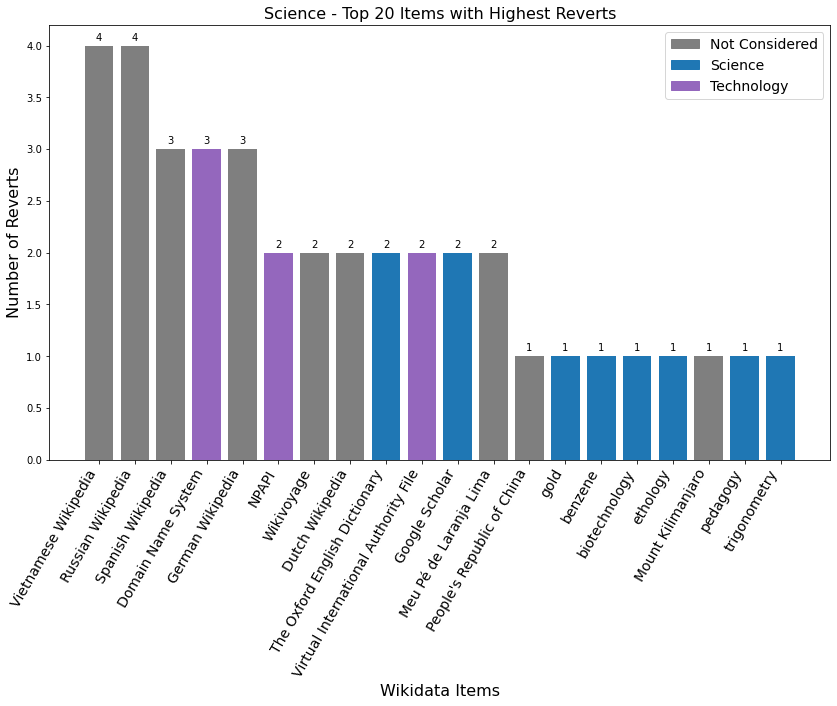

In [95]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:purple', 'tab:gray',
           'tab:purple', 'tab:gray', 'tab:gray', 'tab:blue', 'tab:purple',
           'tab:blue', 'tab:gray', 'tab:gray', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:gray', 'tab:blue', 'tab:blue']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
science = mpatches.Patch(color='tab:blue', label='Science')
tech = mpatches.Patch(color='tab:purple', label='Technology')

plt.legend(handles=[not_considered, science, tech], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Science - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [96]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [97]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
96,Q7922,1,2,0,0,0,0,6,6
251,Q494817,2,2,0,0,0,0,6,4
17,Q2356448,0,1,0,0,0,0,9,5
50,Q2672501,0,1,0,0,0,0,14,1
51,Q2699874,0,1,0,0,0,0,6,5
69,Q569,0,1,0,0,0,1,16,10
90,Q7150,0,1,0,0,0,1,6,5
97,Q8078,0,1,0,0,0,1,13,4
137,Q26963,0,1,0,0,0,1,13,10
142,Q33057,1,1,0,0,0,1,13,9


In [98]:
merge_item_labels = ['pedagogy', 'Google Scholar', 'Kaliningrad Time', 'party per pale', 'neuropsychiatry',
                     'beryllium', 'ecology', 'logic', 'progesterone', 'International Standard Book Number', 
                     'entomology', 'HTTPS', 'Korea Standard Time', 'mechanical engineering', 'electronic engineering', 
                     'pharmacology', 'chloromethyl methyl ether', 'duke', 'Morvan', 'statistical physics']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [99]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
96,Q7922,pedagogy,1,2,0,0,0,0,6,6
251,Q494817,Google Scholar,2,2,0,0,0,0,6,4
17,Q2356448,Kaliningrad Time,0,1,0,0,0,0,9,5
50,Q2672501,party per pale,0,1,0,0,0,0,14,1
51,Q2699874,neuropsychiatry,0,1,0,0,0,0,6,5
69,Q569,beryllium,0,1,0,0,0,1,16,10
90,Q7150,ecology,0,1,0,0,0,1,6,5
97,Q8078,logic,0,1,0,0,0,1,13,4
137,Q26963,progesterone,0,1,0,0,0,1,13,10
142,Q33057,International Standard Book Number,1,1,0,0,0,1,13,9


Text(0.5, 1.0, 'Science - Top 20 Items with Highest Merges')

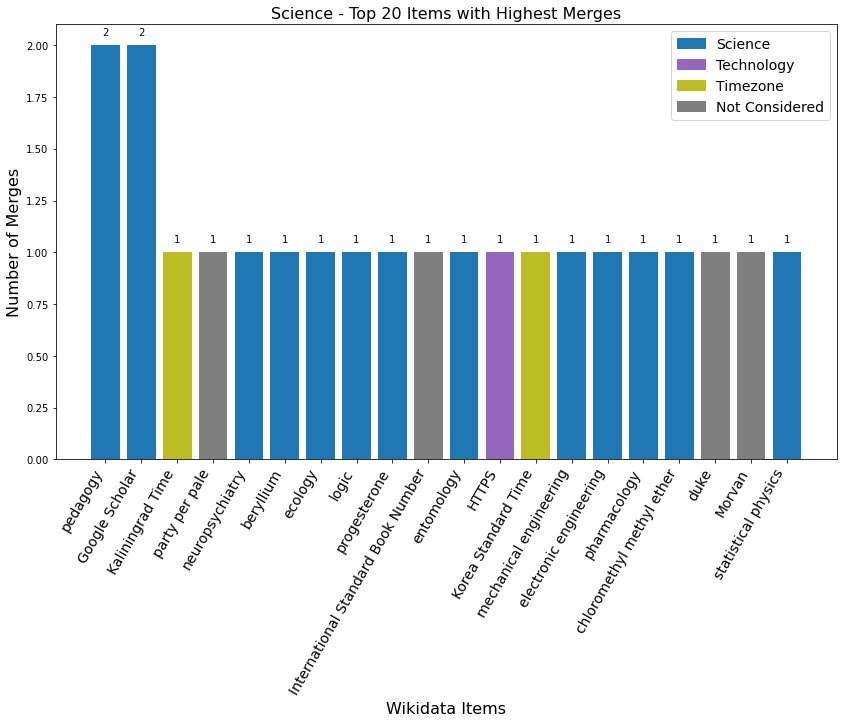

In [107]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:blue', 'tab:blue', 'tab:olive', 'tab:gray', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:gray',
           'tab:blue', 'tab:purple', 'tab:olive', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:gray', 'tab:gray', 'tab:blue']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
science = mpatches.Patch(color='tab:blue', label='Science')
tech = mpatches.Patch(color='tab:purple', label='Technology')
time_zone = mpatches.Patch(color='tab:olive', label='Timezone')                                                                                

plt.legend(handles=[science, tech, time_zone, not_considered], fontsize=14)
plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Science - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [108]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [109]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
102,Q8449,3,0,3,1,0,1,19,8
791,Q196765,0,0,3,0,0,0,6,3
122,Q12199,0,0,2,0,0,0,22,11
179,Q80993,0,0,2,0,0,0,6,3
334,Q1380395,0,0,2,0,0,14,16,2
797,Q202472,0,0,2,0,0,0,10,7
46,Q2657718,0,0,1,0,0,0,8,6
59,Q148,1,0,1,0,0,3,71,33
65,Q413,0,0,1,0,0,2,17,15
86,Q5300,0,0,1,0,0,1,11,9


In [110]:
undo_item_labels = ['Spanish Wikipedia', 'revocation list', 'HIV/AIDS', 'software engineering', 'municipal or urban engineering',
                     'Lithuanian Wikipedia', 'Armenian Soviet Encyclopedia', 'People\'s Republic of China', 'physics', 'central processing unit', 
                     'Amundsen\'s South Pole expedition', 'UNESCO World Heritage Site', 'azathioprine', 'On the Origin of Species', 'IBM', 
                     'German Wikipedia', 'Virtual International Authority File', 'mechanical engineering', 'compulsory education', 'psychological projection']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [111]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
102,Q8449,Spanish Wikipedia,3,0,3,1,0,1,19,8
791,Q196765,revocation list,0,0,3,0,0,0,6,3
122,Q12199,HIV/AIDS,0,0,2,0,0,0,22,11
179,Q80993,software engineering,0,0,2,0,0,0,6,3
334,Q1380395,municipal or urban engineering,0,0,2,0,0,14,16,2
797,Q202472,Lithuanian Wikipedia,0,0,2,0,0,0,10,7
46,Q2657718,Armenian Soviet Encyclopedia,0,0,1,0,0,0,8,6
59,Q148,People's Republic of China,1,0,1,0,0,3,71,33
65,Q413,physics,0,0,1,0,0,2,17,15
86,Q5300,central processing unit,0,0,1,0,0,1,11,9


Text(0.5, 1.0, 'Science - Top 20 Items with Highest Undos')

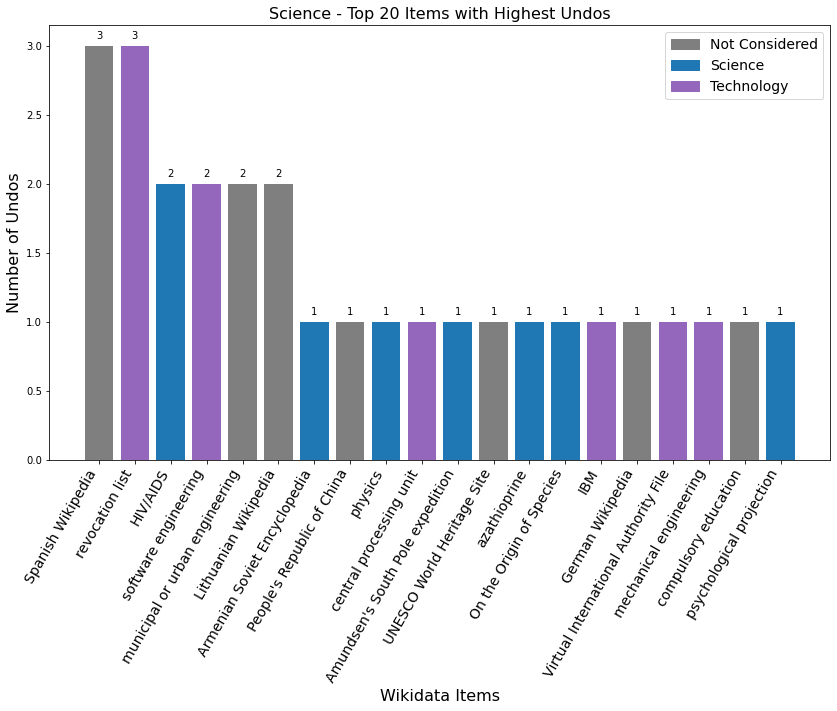

In [128]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:gray', 'tab:purple', 'tab:blue', 'tab:purple', 'tab:gray',
           'tab:grey', 'tab:blue', 'tab:grey', 'tab:blue', 'tab:purple',
           'tab:blue', 'tab:gray', 'tab:blue', 'tab:blue', 'tab:purple',
           'tab:gray', 'tab:purple', 'tab:purple', 'tab:gray', 'tab:blue']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
science = mpatches.Patch(color='tab:blue', label='Science')
tech = mpatches.Patch(color='tab:purple', label='Technology')
timezone = mpatches.Patch(color='tab:olive', label='Timezone')                                                                               

plt.legend(handles=[not_considered, science, tech], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Science - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [129]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [130]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
164,Q48183,3,0,1,2,1,1,19,10
1051,Q934552,1,0,0,2,0,10,36,9
33,Q2532873,2,0,0,1,0,1,9,5
100,Q8414,1,0,1,1,0,3,25,10
102,Q8449,3,0,3,1,0,1,19,8
109,Q10000,2,0,0,1,0,4,10,4
126,Q14116,0,0,0,1,0,3,73,30
165,Q49367,1,0,0,1,0,0,12,9
175,Q61457,0,0,0,1,0,0,18,9
187,Q105650,1,0,0,1,0,0,11,7


In [131]:
restore_item_labels = ['German Wikipedia', 'Yellow Pages', 'NPAPI', 'Amundsen\'s South Pole expedition', 'Spanish Wikipedia',
                     'Dutch Wikipedia', 'macOS', 'ice age', 'acetaldehyde', 'urology', 
                     'chloroform', 'Plastics engineering', 'per pale, the sinister per fess', 'monarch of the United Kingdom', 'Great Soviet Encyclopedia', 
                     'acrylamide', 'lead(II) chromate', 'sodium chromate', 'ammonium chromate', 'acetamide']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [132]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
164,Q48183,German Wikipedia,3,0,1,2,1,1,19,10
1051,Q934552,Yellow Pages,1,0,0,2,0,10,36,9
33,Q2532873,NPAPI,2,0,0,1,0,1,9,5
100,Q8414,Amundsen's South Pole expedition,1,0,1,1,0,3,25,10
102,Q8449,Spanish Wikipedia,3,0,3,1,0,1,19,8
109,Q10000,Dutch Wikipedia,2,0,0,1,0,4,10,4
126,Q14116,macOS,0,0,0,1,0,3,73,30
165,Q49367,ice age,1,0,0,1,0,0,12,9
175,Q61457,acetaldehyde,0,0,0,1,0,0,18,9
187,Q105650,urology,1,0,0,1,0,0,11,7


Text(0.5, 1.0, 'Science - Top 20 Items with Highest Restores')

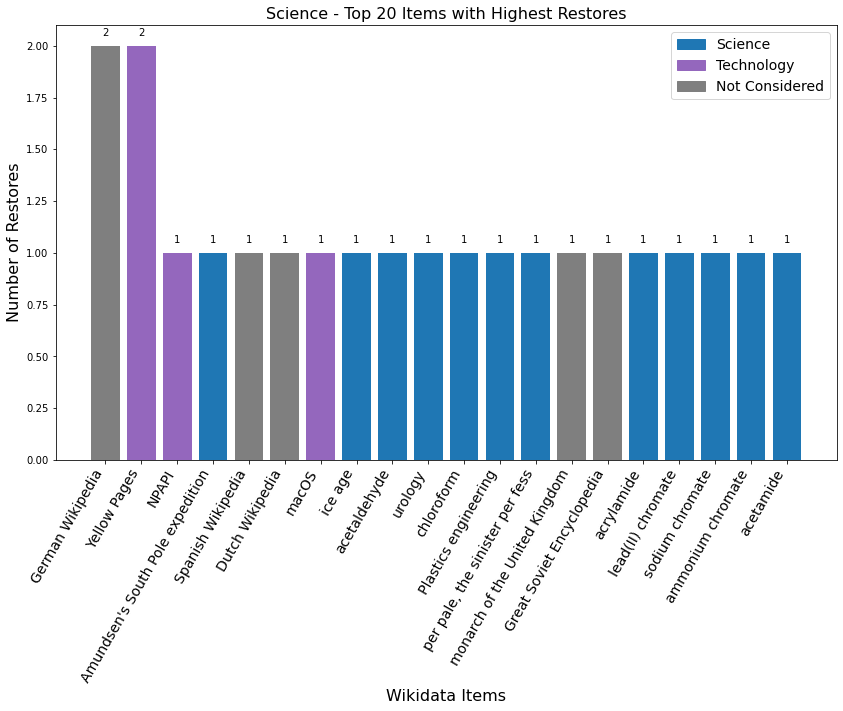

In [138]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:gray', 'tab:purple', 'tab:purple', 'tab:blue', 'tab:gray',
           'tab:gray', 'tab:purple', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:gray',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
science = mpatches.Patch(color='tab:blue', label='Science')
tech = mpatches.Patch(color='tab:purple', label='Technology')
timezone = mpatches.Patch(color='tab:olive', label='Timezone')

plt.legend(handles=[science, tech, not_considered], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Science - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [139]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [140]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
309,Q1276073,0,0,1,0,0,18,105,31
150,Q39286,0,1,0,0,0,1,76,7
126,Q14116,0,0,0,1,0,3,73,30
59,Q148,1,0,1,0,0,3,71,33
134,Q20124,1,0,1,0,0,4,52,7
1051,Q934552,1,0,0,2,0,10,36,9
796,Q200180,4,0,0,0,0,18,34,5
1504,Q27732581,0,1,0,0,0,0,31,2
100,Q8414,1,0,1,1,0,3,25,10
1472,Q27701902,0,1,0,0,0,0,25,3


In [141]:
edit_item_labels = ['Chileans', 'entomology', 'macOS', 'People\'s Republic of China', 'On the Origin of Species',
                     'Yellow Pages', 'Vietnamese Wikipedia', 'hochuekkito', 'Amundsen\'s South Pole expedition', 'anchusan', 
                     'Digital Negative', 'kakkonto', 'Git', 'Russian Wikipedia', 'bakumondoto',  
                     'heiisan', 'Domain Name System', 'HIV/AIDS', 'gokoto', 'goreisan']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [142]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
309,Q1276073,Chileans,0,0,1,0,0,18,105,31
150,Q39286,entomology,0,1,0,0,0,1,76,7
126,Q14116,macOS,0,0,0,1,0,3,73,30
59,Q148,People's Republic of China,1,0,1,0,0,3,71,33
134,Q20124,On the Origin of Species,1,0,1,0,0,4,52,7
1051,Q934552,Yellow Pages,1,0,0,2,0,10,36,9
796,Q200180,Vietnamese Wikipedia,4,0,0,0,0,18,34,5
1504,Q27732581,hochuekkito,0,1,0,0,0,0,31,2
100,Q8414,Amundsen's South Pole expedition,1,0,1,1,0,3,25,10
1472,Q27701902,anchusan,0,1,0,0,0,0,25,3


Text(0.5, 1.0, 'Science - Top 20 Items with Highest Edits')

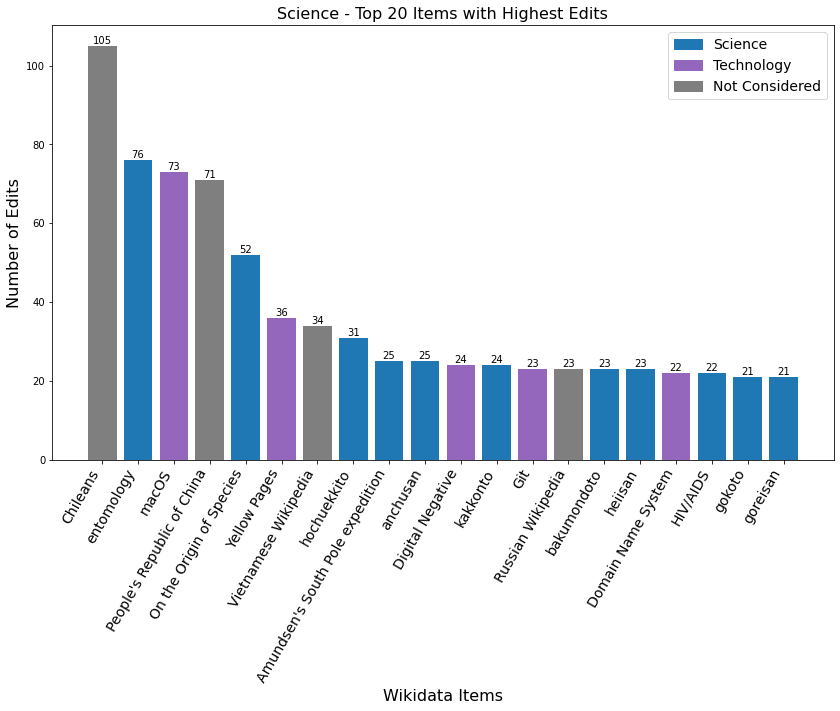

In [152]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')

colours = ['tab:gray', 'tab:blue', 'tab:purple', 'tab:gray', 'tab:blue',
           'tab:purple', 'tab:gray', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:purple', 'tab:blue', 'tab:purple', 'tab:gray', 'tab:blue',
           'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue', 'tab:blue']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
science = mpatches.Patch(color='tab:blue', label='Science')
tech = mpatches.Patch(color='tab:purple', label='Technology')
time_zone = mpatches.Patch(color='tab:olive', label='Timezone')

plt.legend(handles=[science, tech, not_considered], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Science - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [153]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [154]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
59,Q148,1,0,1,0,0,3,71,33
309,Q1276073,0,0,1,0,0,18,105,31
126,Q14116,0,0,0,1,0,3,73,30
65,Q413,0,0,1,0,0,2,17,15
73,Q897,1,0,0,0,0,1,16,15
83,Q2270,1,0,0,0,0,0,16,11
122,Q12199,0,0,2,0,0,0,22,11
802,Q206855,4,0,1,0,0,4,23,11
69,Q569,0,1,0,0,0,1,16,10
100,Q8414,1,0,1,1,0,3,25,10


In [155]:
user_item_labels = ['People\'s Republic of China ', 'Chileans', 'macOS', 'physics ', 'gold',
                     'benzene', 'HIV/AIDS', 'Russian Wikipedia', 'beryllium', 'Amundsen\'s South Pole expedition', 
                     'UNESCO World Heritage Site', 'azathioprine', 'progesterone', 'German Wikipedia', 'Virtual International Authority File',  
                     'testosterone', 'central processing unit', 'ethology', 'Domain Name System', 'International Standard Book Number']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [156]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
59,Q148,People's Republic of China,1,0,1,0,0,3,71,33
309,Q1276073,Chileans,0,0,1,0,0,18,105,31
126,Q14116,macOS,0,0,0,1,0,3,73,30
65,Q413,physics,0,0,1,0,0,2,17,15
73,Q897,gold,1,0,0,0,0,1,16,15
83,Q2270,benzene,1,0,0,0,0,0,16,11
122,Q12199,HIV/AIDS,0,0,2,0,0,0,22,11
802,Q206855,Russian Wikipedia,4,0,1,0,0,4,23,11
69,Q569,beryllium,0,1,0,0,0,1,16,10
100,Q8414,Amundsen's South Pole expedition,1,0,1,1,0,3,25,10


Text(0.5, 1.0, 'Science - Top 20 Items with Highest Users')

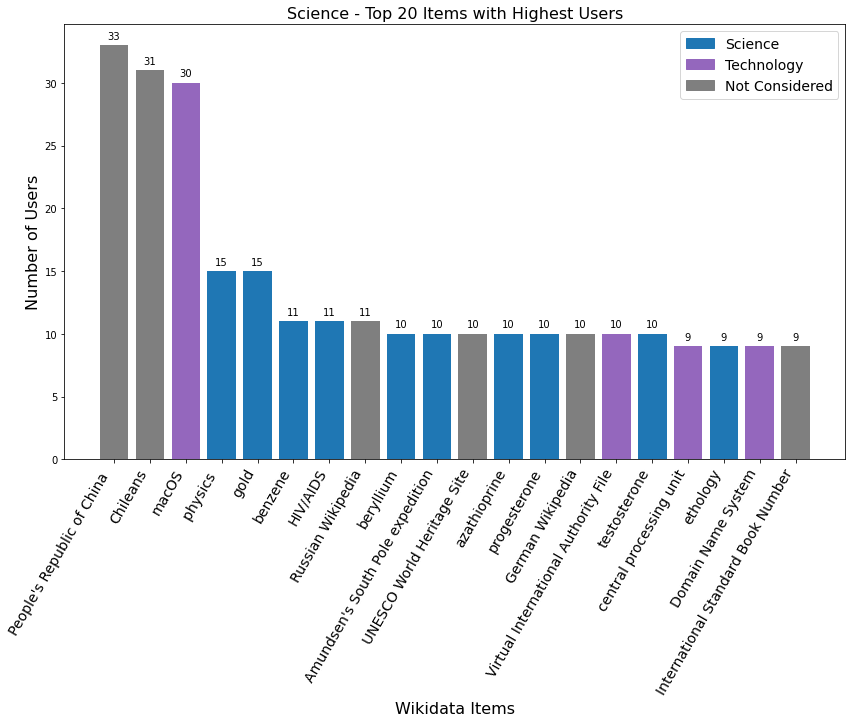

In [161]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:gray', 'tab:gray', 'tab:purple', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:gray', 'tab:blue', 'tab:blue',
           'tab:gray', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:purple',
           'tab:blue', 'tab:purple', 'tab:blue', 'tab:purple', 'tab:gray']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')
science = mpatches.Patch(color='tab:blue', label='Science')
tech = mpatches.Patch(color='tab:purple', label='Technology')
time_zone = mpatches.Patch(color='tab:olive', label='Timezone')

plt.legend(handles=[science, tech, not_considered], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Science - Top 20 Items with Highest Users", fontsize=16)